## Product Color Classification

This project makes use of [FastAI](https://fast.ai) library to train a product color classifier on the [Digikala](https://digikala.com) product dataset released as part of their [data science](https://quera.ir/contest/assignments/20120/problems) competition.

In [1]:
#hide
from fastai.vision.all import *
from PIL import Image

import os
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

/opt/anaconda/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729096996/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
train_path = Path("train")
test_path = Path("test")

fns = get_image_files(train_path)
failed = verify_images(fns)
failed.map(train_path.unlink)

(#0) []

In [5]:
dls = ImageDataLoaders.from_path_func(train_path, get_image_files(train_path), 
                                      label_func=parent_label, seed=42, valid_pct=0.2,
                                      item_tfms=Resize(460), 
                                      batch_tfms=[*aug_transforms(size=224, min_scale=0.75),Normalize.from_stats(*imagenet_stats)]
                                      )

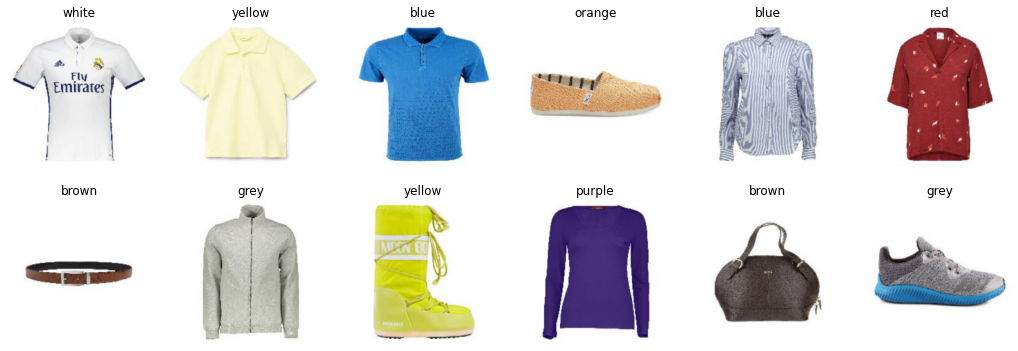

In [11]:
dls.valid.show_batch(max_n=12, nrows=2)

In [35]:
import torchvision

wd=0.1

arch  = torchvision.models.mobilenet_v2
learn = cnn_learner(dls, partial(arch, pretrained=True), cut=-1, wd=wd, metrics=[accuracy]) 

suggested lrs are (0.010000000149011612, 0.0063095735386013985)


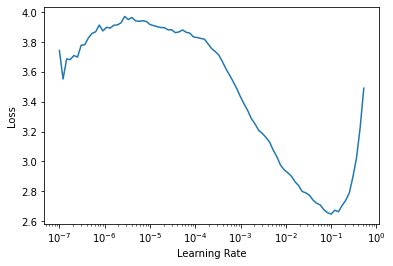

In [36]:
lr_min, lr_steep = learn.lr_find()
print(f"suggested lrs are ({lr_min}, {lr_steep})")

In [37]:
learn.fine_tune(4, base_lr=0.006)

epoch,train_loss,valid_loss,accuracy,time
0,1.526164,1.175271,0.694467,00:45


epoch,train_loss,valid_loss,accuracy,time
0,0.909237,0.942977,0.728949,00:46
1,0.822120,0.862380,0.744186,00:47
2,0.653642,0.774987,0.766640,00:46
3,0.540842,0.793137,0.765036,00:47


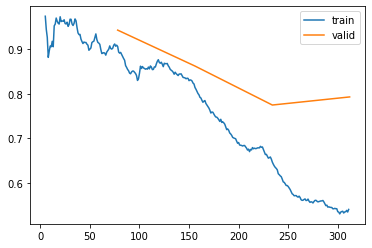

In [38]:
learn.recorder.plot_loss()

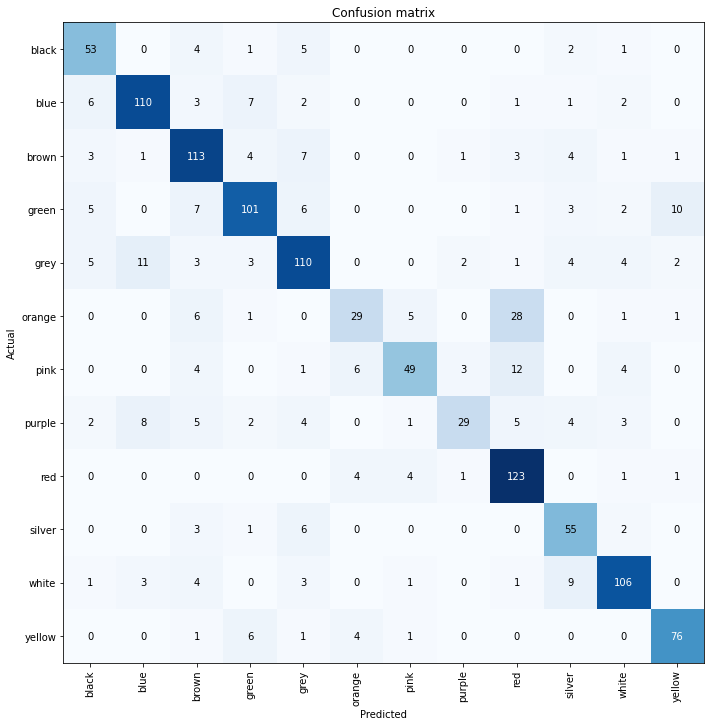

In [39]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10))

In [40]:
interp.most_confused(5)

[('orange', 'red', 28),
 ('pink', 'red', 12),
 ('grey', 'blue', 11),
 ('green', 'yellow', 10),
 ('white', 'silver', 9),
 ('purple', 'blue', 8),
 ('blue', 'green', 7),
 ('brown', 'grey', 7),
 ('green', 'brown', 7),
 ('blue', 'black', 6),
 ('green', 'grey', 6),
 ('orange', 'brown', 6),
 ('pink', 'orange', 6),
 ('silver', 'grey', 6),
 ('yellow', 'green', 6),
 ('black', 'grey', 5),
 ('green', 'black', 5),
 ('grey', 'black', 5),
 ('orange', 'pink', 5),
 ('purple', 'brown', 5),
 ('purple', 'red', 5)]

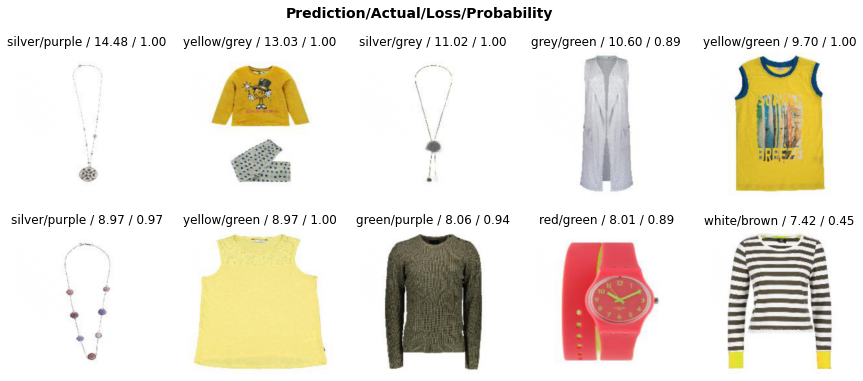

In [41]:
interp.plot_top_losses(10, nrows=2)

In [44]:
path = Path().absolute()

learn.export(path/'export.pkl')